# Import package

In [1]:
import numpy as np
from numpy import nan
from numpy import isnan
from numpy import split
from numpy import array
from numpy import concatenate

import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat

import matplotlib.pyplot as plt
from matplotlib import pyplot
from pylab import *
plt.rcParams['font.sans-serif'] = ['SimHei']

import math
from math import sqrt

import re
import tqdm
import random
import os
import itertools
import argparse
import joblib
import xlrd
from collections import defaultdict
import copy

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn import datasets

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

import datetime
import calendar
import time
from datetime import date,datetime

import xgboost as xgb
from xgboost import plot_importance, plot_tree

import seaborn as sns
import stats as sts#df2

from scipy import stats
from scipy.special import softmax

from keras.models import load_model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import torch
import torch.nn as nn


Bad key "nbagg.transparent" on line 426 in
D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_path" on line 509 in
D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key "animation.mencoder_args" on line 512 in
D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.2/matplotlibrc.template
or from the matplotlib source distribution
In D:\anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.

# Load data

In [2]:
abc=30#表示30min为一段
gdf0=pd.read_csv(r'F:\博士科研资料\博士开题及其素材\加油站数据\export11.csv',encoding='gb18030')
gdf0['Time1'] = pd.to_datetime(gdf0['Time'],errors='coerce') 
gdf0['Hour'] = gdf0['Time1'].dt.hour.fillna(0).astype("int")    #转化提取小时
gdf0['Minute'] = gdf0['Time1'].dt.minute.fillna(0).astype("int") #转化提取分钟
gdf0['Hour']=gdf0['Hour'].astype(str)
gdf0['Date'] = pd.to_datetime(gdf0['Date'])
gdf0['T'] = gdf0['Hour'].apply(lambda x : int(x))+gdf0['Minute'].apply (lambda x :round(x/60,2))
gdf0['volume'] = gdf0['volume']
gdf0['MinuteLabel']=gdf0['Hour'].apply(lambda x : math.floor((int(x)*60)/abc))+gdf0['Minute'].apply (lambda x :math.floor(x/abc))#表示该时刻点属于哪个区间,因为有0，所以向下取整数
day_name00=gdf0.groupby(["NAME"])         #
for name,group in day_name00:#group是星期数一样的类目
    if name=='92H':
        df0=group
df0=df0[df0['Date'] >= "2020-06-01"] 
df0= df0[~( df0['Date'].isin(["2020-06-11","2020-08-11", "2020-08-25", "2020-09-11"]) )]###删除这些行，因为很多0

# Data preprogressing

In [3]:
DFStockOut=df0.iloc[:,[6,7,11,3,10,12]]
c=3
a=DFStockOut.shape[1]
ReStartStock=13790#10000#该变量表示补货到达后的初始库存
DFStockOut['OurLeaveStock']=DFStockOut['Date'].apply(lambda x : ReStartStock)#6
DFStockOut['OurBuHuoStart']=DFStockOut['Date'].apply(lambda x : 0)#补货触发时刻7
b=a+1
DFStockOut['Date']=pd.to_datetime(DFStockOut['Date'])

StockOutTime=[]
DHCS1=0#表示订货次数
DFStockOut['AllMinutes']=DFStockOut['MinuteLabel'].apply(lambda x: time.strftime("%H:%M:%S", time.gmtime( float((x+1)*abc*60))))
#将秒转换为时分秒的形式
for i in range(DFStockOut.shape[0]):
    if DFStockOut.iloc[i,-1]=="00:00:00":
        DFStockOut.iloc[i,-1]="23:59:00"  ###1月20日0:00:00表示的是1月20日24:00:00,而无法取24h，所以设为23.59   
DFStockOut['timestamp']=DFStockOut['Date'].astype('str')+ ' ' + DFStockOut['AllMinutes'].astype('str')
DFStockOut['timestamp'] = pd.to_datetime(DFStockOut['timestamp'])#pd.to_datetime它无法转换
print(DFStockOut.shape)#(321121, 9)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
D:\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

(207441, 10)


D:\anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [4]:
df2 = df0.groupby(["Date","MinuteLabel"])['volume'].sum().reset_index(name ='UnitSales')#只留下小时销量数据
df2['Date'] = pd.to_datetime(df2['Date']) 
df2['Month_id']=df2['Date'].dt.month
df2['weekday'] = df2['Date'].apply(lambda time: time.dayofweek)
df2['MinuteLabel']=df2['MinuteLabel'].astype(str)
df2['weekday_hour'] = df2.weekday.astype(str) +' '+ df2.MinuteLabel.astype(str)
df2['m_weekday'] = df2.weekday_hour.replace(df2[:].groupby('weekday_hour')['UnitSales'].mean().to_dict())
init1 = df2.m_weekday[:].apply(np.log).values#均值取对数df5['UnitSales'
df2['PreproccessUnitSales'] =df2.UnitSales[:].apply(np.log).values - init1#数取对数-均值的对数
dfghu=df2.sort_values(by=['UnitSales'],ascending=[True]) 
df2['UnitSales']=df2['UnitSales'].apply(lambda x: (x-dfghu.iloc[0,2])/(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2]))
df2['MinuteLabel']=df2['MinuteLabel'].astype(int)#

In [5]:
idx=list(range(0,int(24*60/abc)))                                                         
i=0
colorSet=['cyan','g','palegreen','c','lime','tomato','r']
DayName=['Mony','Tues','Wednes', 'Thurs', 'Fri', 'Satur', 'Sun']
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_name=df2.groupby(["weekday"])         #
for name,group in day_name:#group是星期数一样的类目
    group1=group.groupby(["Date"])
    j=0
    for name,group2 in group1:#group2是星期数、日期数一样的类目，即一天  
         #display(group2.head(13))
         group2=group2.sort_values(by=['MinuteLabel'],ascending=True,na_position='first')  # 按时间排序                  
         group2 = group2.set_index('MinuteLabel')#group2设置索引为Hour         
         group2 = group2.reindex(idx, fill_value=0)
         group2['MinuteLabel'] = group2.index          
         group2['Date']=name
         group2['weekday'] = group2['Date'].apply(lambda time: time.dayofweek)
         group2['day_name']=group2['weekday'].apply (lambda x : days[x])
         if i==0 and j==0:
            df3=group2
         else:      
            df3=pd.concat([df3,group2], axis=0, ignore_index=True)#axis:合并方式，默认0表示按列合并，1表示按行合并;ignore_index:是否忽略索引                           
         j=j+1
    i=i+1
df3=df3.sort_values(by=['Date','MinuteLabel'],ascending=[True,True]) #df3是没有的，用0不足的dataframe
df3['HourLabel']=df3['MinuteLabel'].apply(lambda x: math.floor(x*abc/60))

In [6]:
df5=df3.iloc[:,:]
df3['HourLabel']=df3['HourLabel'].astype(int)
df5['weekday'] = df5.Date.dt.weekday
df5['weekday_hour'] = df5.weekday.astype(str) +' '+ df5.HourLabel.astype(str)
df5['m_weekday'] = df5.weekday_hour.replace(df5[:].groupby('weekday_hour')['UnitSales'].mean().to_dict())
df5.to_csv('hour_Demand_consumption.csv')
df5['AllMinutes']=df5['MinuteLabel'].apply(lambda x: time.strftime("%H:%M:%S", time.gmtime( float((x+1)*abc*60))))
for i in range(df5.shape[0]):
    if df5.loc[i,'AllMinutes']=="00:00:00": 
        df5.loc[i,'AllMinutes']="23:59:00"  ###1月20日0:00:00表示的是1月20日24:00:00,而无法取24h，所以设为23.59

df = pd.DataFrame(columns=['timestamp', 'value'])###初始化
df['timestamp']=df5['Date'].astype('str')+ ' ' + df5['AllMinutes'].astype('str')
df['timestamp'] = pd.to_datetime(df['timestamp'])#为什么成了选取偶数
df['value']=df5['UnitSales']
df=df.sort_values(by=['timestamp'],ascending=[True]) 
df['Date']=df['timestamp'].apply(lambda x: x.strftime("%Y-%m-%d"))#提取时间戳中的日期
df['MinuteLabel']=df5['MinuteLabel']
df['yr'] = df.timestamp.dt.year
df['mt'] = df.timestamp.dt.month
df['d'] = df.timestamp.dt.day
df['H'] = df5['HourLabel']
df['Mi'] = df5['MinuteLabel']#表示第几个单位时间
df['weekday'] = df.timestamp.dt.weekday
df['weekday_hour'] = df.weekday.astype(str) +' '+ df.Mi.astype(str)
df['m_weekday'] = df.weekday_hour.replace(df[:].groupby('weekday_hour')['value'].mean().to_dict())
df=df.sort_values(by=['timestamp','Mi'],ascending=[True,True]) #df3是没有的，用0不足的dataframe

# Parameter sensitivity experiment

## Define functions

In [7]:
###00数据裂变划分,用于自定义函数DataPreprogress(df)
def to_supervised2(data, n_input, n_out):#数据裂变划分
    #将所有数据转换为输入(X[..,len(x_input),1])、y[..,len(data[in_end:out_end, 0])]
    X, y = list(), list()
    in_start = 0
    for _ in range(len(data)):# 逐步遍历整个历史数据
        in_end = in_start + n_input## 定义输入序列的结束点
        out_end = in_end + n_out
        if out_end < (len(data)+1):# 确保有足够的数据
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        in_start += 1    # 依次推进时间
    return array(X), array(y)
###01前期数据准备
def DataPreprogress(df):
    init1 = df.m_weekday[:].apply(lambda x: 0).values#均值取对数
    label1 = df.value[:].values - init1#没必要取对数吧
    Date1=df.timestamp[:]#获得对应时间戳
    label1=np.array(label1).reshape(len(label1),1)#1维变2维
    init1=np.array(init1).reshape(len(init1),1)#1维变2维
    Date1=np.array(Date1).reshape(len(Date1),1)
    Xx, Yy = to_supervised2(label1, n_input, n_out)#准备数据#00
    Date1Xx, Date1Yy = to_supervised2(Date1, n_input, n_out)#准备数据#00
    initXx, initYy = to_supervised2(init1, n_input, n_out)#准备数据#00
    return init1,label1,Date1,Xx, Yy,Date1Xx, Date1Yy,initXx,initYy
###02将数据分为测试组和训练组
def split_dataset2(x,y):# split a univariate dataset into train/test sets
    train_x, test_x = x[:SplitNum], x[SplitNum:]
    train_y, test_y = y[:SplitNum], y[SplitNum:]
    return train_x, test_x,train_y, test_y

In [8]:
###02 基于01模型进行预测
def forecast2(model, test_x,inittest_y):#基于model，得到预测值y
    input_x = array(test_x)
    input_x = input_x.reshape((1, len(input_x), 1))# reshape into [1, n_input, 1]
    pred_00=[]
    predd = model.predict(input_x, verbose=0)    
    predd = predd[0]# we only want the vector forecast
    predd = predd.reshape((len(predd), 1))
    pred_00.append(predd)
    pred_00 = np.asarray(pred_00)[:,:,0] 
    pred_00_m = (pred_00[0]+ inittest_y[:])*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2]
    return pred_00_m

###03,测试部分,基于预测模型得到预测值
def PredictValueTest(model,test_x,inittest_y):
    ii=0#表示model1_list
    predictionspredList=[]#得到多个分位数预测模型、不同重复次数下的预测值集合（predictionspredList）
    for ij in range(len(test_x)):
        pred = forecast2(model,test_x[ij,:], inittest_y[ij,:])#得到预测值
        predictionspredList.append(pred)
    predictionspredList = array(predictionspredList)#list转换为数组
    return  predictionspredList

In [9]:
#03评估预测误差
def evaluate_forecasts1(actual, predicted):#返回预测值的总RMSE以及每天RMSE的列表
    scores = list() 
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])#计算MSE
        rmse = sqrt(mse)#计算RMSE
        scores.append(rmse)#计算每个预测值的RMSE,存放在列表#这个现在来看没有多大意义，因为不是同一个时刻,表示向前1步、2步、几步的预测效果
    s = 0
    sMAE = 0
    sMAPE = 0
    RMSE1=list()
    for row in range(actual.shape[0]):
        ss=0
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col]) ** 2
            ss+= (actual[row, col] - predicted[row, col]) ** 2
            sMAE+= np.abs(actual[row, col] - predicted[row, col])
            sMAPE+= np.abs((actual[row, col] - predicted[row, col])/actual[row, col])
        RMSE1.append(sqrt(ss/actual.shape[1]))##每一组的RMSE
    AllNum=actual.shape[0] * actual.shape[1]
    AllRMSE = sqrt(s / AllNum)#计算所有值的RMSE
    AllMSE = s / AllNum#计算所有值的RMSE
    AllMAE =sMAE/AllNum
    AllMAPE =sMAPE/AllNum  
    name='[Num]/RMSE/MSE/MAE/MAPE/q_loss'
    SingPredictscores = list() 
    SingPredictscores.append(AllRMSE)
    SingPredictscores.append(AllMSE)
    SingPredictscores.append(AllMAE)
    SingPredictscores.append(AllMAPE)
    SingPredictscores = ', '.join(['%.1f' % s for s in SingPredictscores])
    return AllRMSE,scores,AllMSE,AllMAE,AllMAPE,AllNum
###06
def summarize_scores(name, score, scores):#总结分数
    s_scores = ', '.join(['%.1f' % s for s in scores])

###04 测试部分，预测结果的传统评价
def  ValueTest(test_y,inittest_y,predictionspredI):
    test_y1=test_y.copy()## 对原始的array1的复制
    for i in range(test_y.shape[0]):
        test_y1[i, :]=(test_y[i, :] + inittest_y[i,:])*(dfghu.iloc[dfghu.shape[0]-1,2]-dfghu.iloc[0,2])+dfghu.iloc[0,2]#不用求exp啦
    PredictScresSet=[]
    AllRMSE,scores,AllMSE,AllMAE,AllMAPE,AllNum=evaluate_forecasts1(test_y1[:, :], predictionspredI)
    PredictScresSet.append(AllRMSE)
    PredictScresSet.append(AllMSE)
    PredictScresSet.append(AllMAE)
    PredictScresSet.append(AllMAPE)
    PredictScresSet.append(AllNum)
    days = range(n_out)
    return PredictScresSet

In [10]:
def run(trial):
    space = {        
        'optimizer':  trial.suggest_categorical('optimizer', [optimizers.Adam]),
        'units': trial.suggest_int('units', 5, 500, 5),
        'epochs': trial.suggest_int('epochs', 10, 100, 10),
        'batch_size': trial.suggest_categorical('batch_size', [8,16, 32, 64, 128, 256, 512]),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 8e-1) }
    model_list = []
    #for i in range(repeats):
    tf.random.set_seed(33)
    tf.random.set_seed(33)
    os.environ['PYTHONHASHSEED'] = str(33)
    np.random.seed(33)
    session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)    
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    model = Sequential()# define model
    model.add(LSTM(units=space['units'], activation='relu', input_shape=(n_timesteps, n_features)))
    ###200表示隐藏状态维度
    model.add(Dense(n_outputs))
    model.compile(optimizer=space['optimizer'](learning_rate=space['learning_rate']), loss='mse')  # 平均误差损失
    history = model.fit(train_x, train_y, epochs=space['epochs'], batch_size=space['batch_size'], verbose=0, shuffle=False)   
    predictionspredList=PredictValueTest(model,test_x,inittest_y)
    PointredictScresSet0=ValueTest(test_y,inittest_y,predictionspredList)
    model.summary()
    p1 = pyplot.plot(history.history['loss'], color='blue', label='train')#画出学习过程
    model_list.append(model)#保存model
    print('PointredictScresSet0[0]',PointredictScresSet0[0])
    return PointredictScresSet0[0]


## Data split

In [23]:
###定义参数取值
n_input =4
n_out = 4
global SplitNum
SplitNum=int((df.shape[0]/int(24*60/abc))*0.7)*int(24*60/abc)-n_input-48*2
###00前期数据准备
init1,label1,Date1,Xx, Yy,Date1Xx, Date1Yy,initXx, initYy=DataPreprogress(df)
##数据拆分
train_x, test_x,train_y, test_y = split_dataset2(Xx, Yy)#01
print('len(train_x), len(test_x),len(train_y), len(test_y)',len(train_x), len(test_x),len(train_y), len(test_y))
print(len(Xx), len(Yy))
inittrain_x, inittest_x,inittrain_y, inittest_y = split_dataset2(initXx, initYy)#01
Datetrain_x, Datetest_x,Datetrain_y, Datetest_y = split_dataset2(Date1Xx, Date1Yy)#01

len(train_x), len(test_x),len(train_y), len(test_y) 6956 3117 6956 3117
10073 10073


In [24]:
print(' Datetest_y [0]',Datetest_y [0])

 Datetest_y [0] ['2020-10-28T00:30:00.000000000' '2020-10-28T01:00:00.000000000'
 '2020-10-28T01:30:00.000000000' '2020-10-28T02:00:00.000000000']


## Concrete hyperparameters based on optuna 

In [25]:
import optuna
from optuna.visualization.matplotlib import plot_optimization_history
from optuna.visualization.matplotlib import plot_param_importances

[I 2022-11-09 09:33:16,057] A new study created in memory with name: no-name-bb95589e-3fb4-4d9c-a9b4-5b5a606b20da
D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:34:11,331] Trial 0 finished with value: 277.59127109914937 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 105, 'epochs': 40, 'batch_size': 512, 'learning_rate': 0.005227708212485873}. Best is trial 0 with value: 277.59127109914937.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 105)               44940     
_________________________________________________________________
dense (Dense)                (None, 4)                 424       
Total params: 45,364
Trainable params: 45,364
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 277.59127109914937


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:35:45,036] Trial 1 finished with value: 276.8594735749174 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 420, 'epochs': 30, 'batch_size': 256, 'learning_rate': 0.01578737359558623}. Best is trial 1 with value: 276.8594735749174.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 420)               708960    
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 1684      
Total params: 710,644
Trainable params: 710,644
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 276.8594735749174


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:40:19,851] Trial 2 finished with value: 290.4351889952334 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 230, 'epochs': 90, 'batch_size': 8, 'learning_rate': 0.03139601904256162}. Best is trial 1 with value: 276.8594735749174.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 230)               213440    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 924       
Total params: 214,364
Trainable params: 214,364
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 290.4351889952334


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:43:21,241] Trial 3 finished with value: 273.51338439019923 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 430, 'epochs': 90, 'batch_size': 128, 'learning_rate': 0.003015345364332576}. Best is trial 3 with value: 273.51338439019923.


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 430)               743040    
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1724      
Total params: 744,764
Trainable params: 744,764
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 273.51338439019923


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:44:39,009] Trial 4 finished with value: 271.88233844991595 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 75, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.0013286349239447087}. Best is trial 4 with value: 271.88233844991595.


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 75)                23100     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 304       
Total params: 23,404
Trainable params: 23,404
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.88233844991595


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:45:36,096] Trial 5 finished with value: 277.1090096147014 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 135, 'epochs': 40, 'batch_size': 256, 'learning_rate': 0.03811830742957212}. Best is trial 4 with value: 271.88233844991595.


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 135)               73980     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 544       
Total params: 74,524
Trainable params: 74,524
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 277.1090096147014


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:47:05,195] Trial 6 finished with value: 275.93887788622595 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 275, 'epochs': 50, 'batch_size': 512, 'learning_rate': 0.031620483157598016}. Best is trial 4 with value: 271.88233844991595.


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 275)               304700    
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 1104      
Total params: 305,804
Trainable params: 305,804
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 275.93887788622595


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 09:57:54,553] Trial 7 finished with value: 271.52210771717466 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 480, 'epochs': 100, 'batch_size': 16, 'learning_rate': 0.010804856227396378}. Best is trial 7 with value: 271.52210771717466.


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 480)               925440    
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 1924      
Total params: 927,364
Trainable params: 927,364
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.52210771717466


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:00:06,878] Trial 8 finished with value: 290.540351799299 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 425, 'epochs': 50, 'batch_size': 256, 'learning_rate': 0.16552468508819235}. Best is trial 7 with value: 271.52210771717466.


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 425)               725900    
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 1704      
Total params: 727,604
Trainable params: 727,604
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 290.540351799299


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:01:03,819] Trial 9 finished with value: 2126.789926243322 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 215, 'epochs': 10, 'batch_size': 512, 'learning_rate': 0.439367424033297}. Best is trial 7 with value: 271.52210771717466.


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 215)               186620    
_________________________________________________________________
dense_9 (Dense)              (None, 4)                 864       
Total params: 187,484
Trainable params: 187,484
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 2126.789926243322


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:08:48,930] Trial 10 finished with value: 298.7179971127801 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 495, 'epochs': 70, 'batch_size': 16, 'learning_rate': 0.12453013618059221}. Best is trial 7 with value: 271.52210771717466.


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 495)               984060    
_________________________________________________________________
dense_10 (Dense)             (None, 4)                 1984      
Total params: 986,044
Trainable params: 986,044
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 298.7179971127801


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:09:58,466] Trial 11 finished with value: 277.2470099304506 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 15, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0012835865468643192}. Best is trial 7 with value: 271.52210771717466.


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 15)                1020      
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 64        
Total params: 1,084
Trainable params: 1,084
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 277.2470099304506


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:12:16,374] Trial 12 finished with value: 271.0804062457834 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 295, 'epochs': 70, 'batch_size': 32, 'learning_rate': 0.0011061576364584252}. Best is trial 12 with value: 271.0804062457834.


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 295)               350460    
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 1184      
Total params: 351,644
Trainable params: 351,644
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.0804062457834


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:14:11,213] Trial 13 finished with value: 270.816006599754 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 305, 'epochs': 70, 'batch_size': 64, 'learning_rate': 0.008116887885133817}. Best is trial 13 with value: 270.816006599754.


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 305)               374540    
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 1224      
Total params: 375,764
Trainable params: 375,764
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.816006599754


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:16:06,846] Trial 14 finished with value: 272.5902687281405 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 315, 'epochs': 70, 'batch_size': 64, 'learning_rate': 0.0037006430400167334}. Best is trial 13 with value: 270.816006599754.


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 315)               399420    
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 1264      
Total params: 400,684
Trainable params: 400,684
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.5902687281405


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:18:16,222] Trial 15 finished with value: 272.12909184771974 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 345, 'epochs': 70, 'batch_size': 64, 'learning_rate': 0.008421977920882109}. Best is trial 13 with value: 270.816006599754.


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 345)               478860    
_________________________________________________________________
dense_15 (Dense)             (None, 4)                 1384      
Total params: 480,244
Trainable params: 480,244
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.12909184771974


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:19:25,844] Trial 16 finished with value: 274.7080660628813 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 180, 'epochs': 60, 'batch_size': 64, 'learning_rate': 0.001171529502796272}. Best is trial 13 with value: 270.816006599754.


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 180)               131040    
_________________________________________________________________
dense_16 (Dense)             (None, 4)                 724       
Total params: 131,764
Trainable params: 131,764
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 274.7080660628813


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:22:38,606] Trial 17 finished with value: 270.72324752607005 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 350, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.0032622816509268013}. Best is trial 17 with value: 270.72324752607005.


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 350)               492800    
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 1404      
Total params: 494,204
Trainable params: 494,204
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.72324752607005


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:31:27,676] Trial 18 finished with value: 272.1407334035454 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 365, 'epochs': 80, 'batch_size': 8, 'learning_rate': 0.002786890558012828}. Best is trial 17 with value: 270.72324752607005.


Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 365)               535820    
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 1464      
Total params: 537,284
Trainable params: 537,284
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.1407334035454


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:33:27,909] Trial 19 finished with value: 276.8466653683193 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 370, 'epochs': 60, 'batch_size': 128, 'learning_rate': 0.07697270632390876}. Best is trial 17 with value: 270.72324752607005.


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 370)               550560    
_________________________________________________________________
dense_19 (Dense)             (None, 4)                 1484      
Total params: 552,044
Trainable params: 552,044
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 276.8466653683193


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:35:46,735] Trial 20 finished with value: 270.32783273950616 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 250, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.014487674235815614}. Best is trial 20 with value: 270.32783273950616.


Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 250)               252000    
_________________________________________________________________
dense_20 (Dense)             (None, 4)                 1004      
Total params: 253,004
Trainable params: 253,004
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.32783273950616


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:38:08,790] Trial 21 finished with value: 271.55140392822346 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 255, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.016635753409037016}. Best is trial 20 with value: 270.32783273950616.


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 255)               262140    
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 1024      
Total params: 263,164
Trainable params: 263,164
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.55140392822346


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:39:46,749] Trial 22 finished with value: 271.0128461079127 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 185, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.006785885123854205}. Best is trial 20 with value: 270.32783273950616.


Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_22 (LSTM)               (None, 185)               138380    
_________________________________________________________________
dense_22 (Dense)             (None, 4)                 744       
Total params: 139,124
Trainable params: 139,124
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.0128461079127


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:42:11,235] Trial 23 finished with value: 271.9819041583589 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 325, 'epochs': 90, 'batch_size': 64, 'learning_rate': 0.01544963136599711}. Best is trial 20 with value: 270.32783273950616.


Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 325)               425100    
_________________________________________________________________
dense_23 (Dense)             (None, 4)                 1304      
Total params: 426,404
Trainable params: 426,404
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.9819041583589


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:45:54,400] Trial 24 finished with value: 272.16198478046715 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 390, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.002152400588487433}. Best is trial 20 with value: 270.32783273950616.


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 390)               611520    
_________________________________________________________________
dense_24 (Dense)             (None, 4)                 1564      
Total params: 613,084
Trainable params: 613,084
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.16198478046715


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:47:55,244] Trial 25 finished with value: 271.08977414257413 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 280, 'epochs': 60, 'batch_size': 32, 'learning_rate': 0.004570817584405362}. Best is trial 20 with value: 270.32783273950616.


Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 280)               315840    
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 1124      
Total params: 316,964
Trainable params: 316,964
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.08977414257413


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:49:47,479] Trial 26 finished with value: 273.13851424337867 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 240, 'epochs': 100, 'batch_size': 64, 'learning_rate': 0.061341901883483846}. Best is trial 20 with value: 270.32783273950616.


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 240)               232320    
_________________________________________________________________
dense_26 (Dense)             (None, 4)                 964       
Total params: 233,284
Trainable params: 233,284
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 273.13851424337867


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:51:30,380] Trial 27 finished with value: 272.63994460736717 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 190, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.010260625804990974}. Best is trial 20 with value: 270.32783273950616.


Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 190)               145920    
_________________________________________________________________
dense_27 (Dense)             (None, 4)                 764       
Total params: 146,684
Trainable params: 146,684
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.63994460736717


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 10:59:47,652] Trial 28 finished with value: 275.1008926467776 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 320, 'epochs': 90, 'batch_size': 8, 'learning_rate': 0.020629235354376232}. Best is trial 20 with value: 270.32783273950616.


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_28 (LSTM)               (None, 320)               412160    
_________________________________________________________________
dense_28 (Dense)             (None, 4)                 1284      
Total params: 413,444
Trainable params: 413,444
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 275.1008926467776


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:00:44,629] Trial 29 finished with value: 279.86289086588664 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 100, 'epochs': 10, 'batch_size': 16, 'learning_rate': 0.006397362313192616}. Best is trial 20 with value: 270.32783273950616.


Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_29 (Dense)             (None, 4)                 404       
Total params: 41,204
Trainable params: 41,204
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 279.86289086588664


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:01:43,259] Trial 30 finished with value: 276.2159541069979 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 150, 'epochs': 30, 'batch_size': 128, 'learning_rate': 0.005057971149571}. Best is trial 20 with value: 270.32783273950616.


Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 150)               91200     
_________________________________________________________________
dense_30 (Dense)             (None, 4)                 604       
Total params: 91,804
Trainable params: 91,804
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 276.2159541069979


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:03:34,394] Trial 31 finished with value: 270.31621677131477 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 200, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.007153903256987928}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_31 (Dense)             (None, 4)                 804       
Total params: 162,404
Trainable params: 162,404
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.31621677131477


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:05:35,718] Trial 32 finished with value: 270.9336378676605 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 255, 'epochs': 70, 'batch_size': 32, 'learning_rate': 0.0024381132526994755}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 255)               262140    
_________________________________________________________________
dense_32 (Dense)             (None, 4)                 1024      
Total params: 263,164
Trainable params: 263,164
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.9336378676605


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:07:34,849] Trial 33 finished with value: 270.86288561186655 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 215, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.011184107402379514}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 215)               186620    
_________________________________________________________________
dense_33 (Dense)             (None, 4)                 864       
Total params: 187,484
Trainable params: 187,484
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.86288561186655


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:10:26,005] Trial 34 finished with value: 270.5479572952253 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 290, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.0019105189915318054}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 290)               338720    
_________________________________________________________________
dense_34 (Dense)             (None, 4)                 1164      
Total params: 339,884
Trainable params: 339,884
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.5479572952253


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:12:05,498] Trial 35 finished with value: 271.0505181906493 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 145, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0018866981956658436}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 145)               85260     
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 584       
Total params: 85,844
Trainable params: 85,844
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.0505181906493


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:16:29,188] Trial 36 finished with value: 272.5653373644845 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 400, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.0038494540488001514}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 400)               643200    
_________________________________________________________________
dense_36 (Dense)             (None, 4)                 1604      
Total params: 644,804
Trainable params: 644,804
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.5653373644845


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:23:02,429] Trial 37 finished with value: 271.3865361530652 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 455, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.0016079981833952855}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 455)               831740    
_________________________________________________________________
dense_37 (Dense)             (None, 4)                 1824      
Total params: 833,564
Trainable params: 833,564
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.3865361530652


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:25:08,835] Trial 38 finished with value: 274.2260986440297 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 270, 'epochs': 100, 'batch_size': 512, 'learning_rate': 0.0034119525516709917}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_38 (LSTM)               (None, 270)               293760    
_________________________________________________________________
dense_38 (Dense)             (None, 4)                 1084      
Total params: 294,844
Trainable params: 294,844
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 274.2260986440297


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:27:51,465] Trial 39 finished with value: 272.10663612176984 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 340, 'epochs': 90, 'batch_size': 256, 'learning_rate': 0.024475635552460333}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 340)               465120    
_________________________________________________________________
dense_39 (Dense)             (None, 4)                 1364      
Total params: 466,484
Trainable params: 466,484
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.10663612176984


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:30:19,827] Trial 40 finished with value: 270.35442587675533 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 225, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.0060801865122234585}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 225)               204300    
_________________________________________________________________
dense_40 (Dense)             (None, 4)                 904       
Total params: 205,204
Trainable params: 205,204
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.35442587675533


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:32:28,394] Trial 41 finished with value: 270.66348537417247 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 220, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.013957994702768544}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 220)               195360    
_________________________________________________________________
dense_41 (Dense)             (None, 4)                 884       
Total params: 196,244
Trainable params: 196,244
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.66348537417247


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:34:53,122] Trial 42 finished with value: 276.5031830720915 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 220, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.04764790408193072}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 220)               195360    
_________________________________________________________________
dense_42 (Dense)             (None, 4)                 884       
Total params: 196,244
Trainable params: 196,244
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 276.5031830720915


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:36:58,973] Trial 43 finished with value: 272.3951825495207 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 165, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.0160954453428329}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 165)               110220    
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 664       
Total params: 110,884
Trainable params: 110,884
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.3951825495207


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:38:49,818] Trial 44 finished with value: 271.3791756357638 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 115, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.012700141923184785}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 115)               53820     
_________________________________________________________________
dense_44 (Dense)             (None, 4)                 464       
Total params: 54,284
Trainable params: 54,284
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.3791756357638


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:40:07,789] Trial 45 finished with value: 274.491913388958 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 200, 'epochs': 50, 'batch_size': 256, 'learning_rate': 0.032307737763066516}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_45 (Dense)             (None, 4)                 804       
Total params: 162,404
Trainable params: 162,404
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 274.491913388958


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:41:46,327] Trial 46 finished with value: 274.9348239219348 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 245, 'epochs': 70, 'batch_size': 512, 'learning_rate': 0.006368285725756377}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 245)               242060    
_________________________________________________________________
dense_46 (Dense)             (None, 4)                 984       
Total params: 243,044
Trainable params: 243,044
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 274.9348239219348


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:46:13,562] Trial 47 finished with value: 274.3995972226629 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 285, 'epochs': 80, 'batch_size': 16, 'learning_rate': 0.021605463391941703}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 285)               327180    
_________________________________________________________________
dense_47 (Dense)             (None, 4)                 1144      
Total params: 328,324
Trainable params: 328,324
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 274.3995972226629


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:48:04,119] Trial 48 finished with value: 274.3898405946849 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 230, 'epochs': 20, 'batch_size': 8, 'learning_rate': 0.00830746107655828}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 230)               213440    
_________________________________________________________________
dense_48 (Dense)             (None, 4)                 924       
Total params: 214,364
Trainable params: 214,364
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 274.3898405946849


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:49:34,733] Trial 49 finished with value: 644.1439718141427 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 30, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.3539850896370184}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 30)                3840      
_________________________________________________________________
dense_49 (Dense)             (None, 4)                 124       
Total params: 3,964
Trainable params: 3,964
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 644.1439718141427


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:51:08,266] Trial 50 finished with value: 272.96369993202626 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 200, 'epochs': 70, 'batch_size': 128, 'learning_rate': 0.004836064048752388}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 200)               161600    
_________________________________________________________________
dense_50 (Dense)             (None, 4)                 804       
Total params: 162,404
Trainable params: 162,404
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.96369993202626


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:53:43,331] Trial 51 finished with value: 270.60314266323644 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 260, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.00270549907973615}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 260)               272480    
_________________________________________________________________
dense_51 (Dense)             (None, 4)                 1044      
Total params: 273,524
Trainable params: 273,524
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.60314266323644


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:56:45,173] Trial 52 finished with value: 270.81041351497885 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 265, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.0016512872179380502}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_52 (LSTM)               (None, 265)               283020    
_________________________________________________________________
dense_52 (Dense)             (None, 4)                 1064      
Total params: 284,084
Trainable params: 284,084
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.81041351497885


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 11:59:19,340] Trial 53 finished with value: 271.6977715855327 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 300, 'epochs': 60, 'batch_size': 32, 'learning_rate': 0.009129963464125904}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 300)               362400    
_________________________________________________________________
dense_53 (Dense)             (None, 4)                 1204      
Total params: 363,604
Trainable params: 363,604
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.6977715855327


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:01:51,315] Trial 54 finished with value: 271.621560158374 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 225, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.0024297687895726114}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 225)               204300    
_________________________________________________________________
dense_54 (Dense)             (None, 4)                 904       
Total params: 205,204
Trainable params: 205,204
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.621560158374


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:03:59,686] Trial 55 finished with value: 270.75338202630644 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 165, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.006509697215063885}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 165)               110220    
_________________________________________________________________
dense_55 (Dense)             (None, 4)                 664       
Total params: 110,884
Trainable params: 110,884
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.75338202630644


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:06:19,617] Trial 56 finished with value: 271.45050094456127 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 240, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.012637389308547665}. Best is trial 31 with value: 270.31621677131477.


Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 240)               232320    
_________________________________________________________________
dense_56 (Dense)             (None, 4)                 964       
Total params: 233,284
Trainable params: 233,284
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.45050094456127


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:08:13,168] Trial 57 finished with value: 270.0976989005938 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 205, 'epochs': 70, 'batch_size': 32, 'learning_rate': 0.003976844526474616}. Best is trial 57 with value: 270.0976989005938.


Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 205)               169740    
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 824       
Total params: 170,564
Trainable params: 170,564
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.0976989005938


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:09:31,226] Trial 58 finished with value: 275.1208582369378 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 170, 'epochs': 70, 'batch_size': 256, 'learning_rate': 0.004394904857118203}. Best is trial 57 with value: 270.0976989005938.


Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 170)               116960    
_________________________________________________________________
dense_58 (Dense)             (None, 4)                 684       
Total params: 117,644
Trainable params: 117,644
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 275.1208582369378


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:11:10,334] Trial 59 finished with value: 270.93577394713475 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 125, 'epochs': 70, 'batch_size': 32, 'learning_rate': 0.0013360552342451114}. Best is trial 57 with value: 270.0976989005938.


Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_59 (LSTM)               (None, 125)               63500     
_________________________________________________________________
dense_59 (Dense)             (None, 4)                 504       
Total params: 64,004
Trainable params: 64,004
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.93577394713475


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:12:34,572] Trial 60 finished with value: 276.2432795488424 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 205, 'epochs': 60, 'batch_size': 512, 'learning_rate': 0.0026996557743455994}. Best is trial 57 with value: 270.0976989005938.


Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 205)               169740    
_________________________________________________________________
dense_60 (Dense)             (None, 4)                 824       
Total params: 170,564
Trainable params: 170,564
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 276.2432795488424


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:15:59,916] Trial 61 finished with value: 269.5370805346891 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 285, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.0032715725806322527}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 285)               327180    
_________________________________________________________________
dense_61 (Dense)             (None, 4)                 1144      
Total params: 328,324
Trainable params: 328,324
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 269.5370805346891


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:19:23,821] Trial 62 finished with value: 271.7702482810649 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 290, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.0034648197661042205}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 290)               338720    
_________________________________________________________________
dense_62 (Dense)             (None, 4)                 1164      
Total params: 339,884
Trainable params: 339,884
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.7702482810649


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:22:31,635] Trial 63 finished with value: 270.999280499672 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 260, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.006166761413591992}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_63 (LSTM)               (None, 260)               272480    
_________________________________________________________________
dense_63 (Dense)             (None, 4)                 1044      
Total params: 273,524
Trainable params: 273,524
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.999280499672


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:26:38,642] Trial 64 finished with value: 271.2217350959735 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 275, 'epochs': 70, 'batch_size': 16, 'learning_rate': 0.0018475173372590765}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 275)               304700    
_________________________________________________________________
dense_64 (Dense)             (None, 4)                 1104      
Total params: 305,804
Trainable params: 305,804
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.2217350959735


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:29:12,105] Trial 65 finished with value: 271.11637777854065 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 330, 'epochs': 40, 'batch_size': 32, 'learning_rate': 0.004330876389088277}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_65 (LSTM)               (None, 330)               438240    
_________________________________________________________________
dense_65 (Dense)             (None, 4)                 1324      
Total params: 439,564
Trainable params: 439,564
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.11637777854065


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:38:22,341] Trial 66 finished with value: 272.5916069348069 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 305, 'epochs': 80, 'batch_size': 8, 'learning_rate': 0.0010594577326640104}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_66 (LSTM)               (None, 305)               374540    
_________________________________________________________________
dense_66 (Dense)             (None, 4)                 1224      
Total params: 375,764
Trainable params: 375,764
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.5916069348069


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:40:17,250] Trial 67 finished with value: 271.88397713338736 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 240, 'epochs': 90, 'batch_size': 128, 'learning_rate': 0.0030143278672954453}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 240)               232320    
_________________________________________________________________
dense_67 (Dense)             (None, 4)                 964       
Total params: 233,284
Trainable params: 233,284
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.88397713338736


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:42:14,509] Trial 68 finished with value: 270.75527055343383 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 190, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.0021670135159056487}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 190)               145920    
_________________________________________________________________
dense_68 (Dense)             (None, 4)                 764       
Total params: 146,684
Trainable params: 146,684
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.75527055343383


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:44:58,506] Trial 69 finished with value: 271.73124573881165 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 255, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.007506753622319829}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_69 (LSTM)               (None, 255)               262140    
_________________________________________________________________
dense_69 (Dense)             (None, 4)                 1024      
Total params: 263,164
Trainable params: 263,164
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.73124573881165


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:47:24,386] Trial 70 finished with value: 270.88879514328687 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 285, 'epochs': 50, 'batch_size': 32, 'learning_rate': 0.005437298078074213}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_70 (LSTM)               (None, 285)               327180    
_________________________________________________________________
dense_70 (Dense)             (None, 4)                 1144      
Total params: 328,324
Trainable params: 328,324
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.88879514328687


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:49:34,936] Trial 71 finished with value: 271.2742505590276 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 215, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.009557990662113148}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_71 (LSTM)               (None, 215)               186620    
_________________________________________________________________
dense_71 (Dense)             (None, 4)                 864       
Total params: 187,484
Trainable params: 187,484
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.2742505590276


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:52:58,977] Trial 72 finished with value: 270.8208134139062 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 310, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.011778599904941572}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 310)               386880    
_________________________________________________________________
dense_72 (Dense)             (None, 4)                 1244      
Total params: 388,124
Trainable params: 388,124
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.8208134139062


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:55:30,676] Trial 73 finished with value: 270.84808024292636 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 235, 'epochs': 70, 'batch_size': 32, 'learning_rate': 0.005503317305568821}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_73 (LSTM)               (None, 235)               222780    
_________________________________________________________________
dense_73 (Dense)             (None, 4)                 944       
Total params: 223,724
Trainable params: 223,724
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.84808024292636


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:57:29,108] Trial 74 finished with value: 271.90221259130715 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 180, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.018253848193462825}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_74 (LSTM)               (None, 180)               131040    
_________________________________________________________________
dense_74 (Dense)             (None, 4)                 724       
Total params: 131,764
Trainable params: 131,764
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.90221259130715


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 12:59:41,559] Trial 75 finished with value: 272.6417328407163 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 265, 'epochs': 80, 'batch_size': 64, 'learning_rate': 0.0014392580241157657}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_75 (LSTM)               (None, 265)               283020    
_________________________________________________________________
dense_75 (Dense)             (None, 4)                 1064      
Total params: 284,084
Trainable params: 284,084
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.6417328407163


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:01:45,697] Trial 76 finished with value: 271.58416887737036 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 150, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.013863699079970556}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_76 (LSTM)               (None, 150)               91200     
_________________________________________________________________
dense_76 (Dense)             (None, 4)                 604       
Total params: 91,804
Trainable params: 91,804
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.58416887737036


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:04:11,617] Trial 77 finished with value: 270.21443635991346 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 210, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.00295734714012063}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_77 (LSTM)               (None, 210)               178080    
_________________________________________________________________
dense_77 (Dense)             (None, 4)                 844       
Total params: 178,924
Trainable params: 178,924
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.21443635991346


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:06:43,315] Trial 78 finished with value: 271.45012821332807 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 205, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.0038312635911667632}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_78 (LSTM)               (None, 205)               169740    
_________________________________________________________________
dense_78 (Dense)             (None, 4)                 824       
Total params: 170,564
Trainable params: 170,564
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.45012821332807


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:09:32,829] Trial 79 finished with value: 271.3367220666912 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 250, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.0026431672845321818}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_79 (LSTM)               (None, 250)               252000    
_________________________________________________________________
dense_79 (Dense)             (None, 4)                 1004      
Total params: 253,004
Trainable params: 253,004
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.3367220666912


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:14:50,311] Trial 80 finished with value: 270.8250149899449 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 230, 'epochs': 90, 'batch_size': 8, 'learning_rate': 0.0020874210398454033}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_80 (LSTM)               (None, 230)               213440    
_________________________________________________________________
dense_80 (Dense)             (None, 4)                 924       
Total params: 214,364
Trainable params: 214,364
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.8250149899449


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:17:15,185] Trial 81 finished with value: 271.14931143987667 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 210, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.0032720304409201593}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_81 (LSTM)               (None, 210)               178080    
_________________________________________________________________
dense_81 (Dense)             (None, 4)                 844       
Total params: 178,924
Trainable params: 178,924
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.14931143987667


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:19:18,732] Trial 82 finished with value: 270.3161035366606 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 185, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.0039384076904983405}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_82 (LSTM)               (None, 185)               138380    
_________________________________________________________________
dense_82 (Dense)             (None, 4)                 744       
Total params: 139,124
Trainable params: 139,124
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.3161035366606


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:21:25,542] Trial 83 finished with value: 271.0634162054251 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 185, 'epochs': 90, 'batch_size': 32, 'learning_rate': 0.004014381623386879}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_83 (LSTM)               (None, 185)               138380    
_________________________________________________________________
dense_83 (Dense)             (None, 4)                 744       
Total params: 139,124
Trainable params: 139,124
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.0634162054251


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:25:28,862] Trial 84 finished with value: 271.83311148814755 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 275, 'epochs': 70, 'batch_size': 16, 'learning_rate': 0.002790432222140236}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 275)               304700    
_________________________________________________________________
dense_84 (Dense)             (None, 4)                 1104      
Total params: 305,804
Trainable params: 305,804
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.83311148814755


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:27:20,285] Trial 85 finished with value: 270.58106471293206 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 175, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.005447963220561313}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_85 (LSTM)               (None, 175)               123900    
_________________________________________________________________
dense_85 (Dense)             (None, 4)                 704       
Total params: 124,604
Trainable params: 124,604
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.58106471293206


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:28:36,905] Trial 86 finished with value: 274.2003289986282 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 95, 'epochs': 90, 'batch_size': 256, 'learning_rate': 0.004999806035075479}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_86"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_86 (LSTM)               (None, 95)                36860     
_________________________________________________________________
dense_86 (Dense)             (None, 4)                 384       
Total params: 37,244
Trainable params: 37,244
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 274.2003289986282


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:29:52,875] Trial 87 finished with value: 274.8478228869131 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 170, 'epochs': 70, 'batch_size': 512, 'learning_rate': 0.0076194599091767515}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_87 (LSTM)               (None, 170)               116960    
_________________________________________________________________
dense_87 (Dense)             (None, 4)                 684       
Total params: 117,644
Trainable params: 117,644
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 274.8478228869131


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:32:01,468] Trial 88 finished with value: 317.92499992696213 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 195, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.6865648211230794}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 195)               153660    
_________________________________________________________________
dense_88 (Dense)             (None, 4)                 784       
Total params: 154,444
Trainable params: 154,444
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 317.92499992696213


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:33:28,123] Trial 89 finished with value: 272.1170489363339 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 135, 'epochs': 90, 'batch_size': 128, 'learning_rate': 0.005729600226557349}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_89 (LSTM)               (None, 135)               73980     
_________________________________________________________________
dense_89 (Dense)             (None, 4)                 544       
Total params: 74,524
Trainable params: 74,524
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.1170489363339


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:35:21,927] Trial 90 finished with value: 271.6103433556821 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 160, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.00733933912836065}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_90 (LSTM)               (None, 160)               103680    
_________________________________________________________________
dense_90 (Dense)             (None, 4)                 644       
Total params: 104,324
Trainable params: 104,324
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.6103433556821


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:37:49,049] Trial 91 finished with value: 271.37405815375826 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 225, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.002271410165532097}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_91 (LSTM)               (None, 225)               204300    
_________________________________________________________________
dense_91 (Dense)             (None, 4)                 904       
Total params: 205,204
Trainable params: 205,204
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.37405815375826


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:39:47,787] Trial 92 finished with value: 270.5159533105471 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 175, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.0017190204355141544}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_92 (LSTM)               (None, 175)               123900    
_________________________________________________________________
dense_92 (Dense)             (None, 4)                 704       
Total params: 124,604
Trainable params: 124,604
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.5159533105471


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:41:41,629] Trial 93 finished with value: 271.48628582192447 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 155, 'epochs': 70, 'batch_size': 32, 'learning_rate': 0.0017902834620415206}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 155)               97340     
_________________________________________________________________
dense_93 (Dense)             (None, 4)                 624       
Total params: 97,964
Trainable params: 97,964
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.48628582192447


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:43:59,294] Trial 94 finished with value: 270.7878701725141 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 190, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.0034425227086690427}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_94 (LSTM)               (None, 190)               145920    
_________________________________________________________________
dense_94 (Dense)             (None, 4)                 764       
Total params: 146,684
Trainable params: 146,684
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.7878701725141


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:45:46,641] Trial 95 finished with value: 272.8386895045678 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 180, 'epochs': 90, 'batch_size': 64, 'learning_rate': 0.0015693989296035609}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_95 (LSTM)               (None, 180)               131040    
_________________________________________________________________
dense_95 (Dense)             (None, 4)                 724       
Total params: 131,764
Trainable params: 131,764
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.8386895045678


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:47:55,851] Trial 96 finished with value: 271.1351267379516 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 145, 'epochs': 100, 'batch_size': 32, 'learning_rate': 0.004499580240756598}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_96 (LSTM)               (None, 145)               85260     
_________________________________________________________________
dense_96 (Dense)             (None, 4)                 584       
Total params: 85,844
Trainable params: 85,844
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 271.1351267379516


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:49:54,897] Trial 97 finished with value: 270.86412630977077 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 175, 'epochs': 80, 'batch_size': 32, 'learning_rate': 0.010126661236518257}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_97 (LSTM)               (None, 175)               123900    
_________________________________________________________________
dense_97 (Dense)             (None, 4)                 704       
Total params: 124,604
Trainable params: 124,604
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.86412630977077


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:51:51,699] Trial 98 finished with value: 270.86531031077806 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 215, 'epochs': 60, 'batch_size': 32, 'learning_rate': 0.003919097214381394}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_98 (LSTM)               (None, 215)               186620    
_________________________________________________________________
dense_98 (Dense)             (None, 4)                 864       
Total params: 187,484
Trainable params: 187,484
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 270.86531031077806


D:\anaconda\lib\site-packages\optuna\distributions.py:427: UserWarning:

Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> which is of type ABCMeta.

[I 2022-11-09 13:53:24,296] Trial 99 finished with value: 272.2686183704997 and parameters: {'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'units': 135, 'epochs': 70, 'batch_size': 32, 'learning_rate': 0.0011745889419518417}. Best is trial 61 with value: 269.5370805346891.


Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 135)               73980     
_________________________________________________________________
dense_99 (Dense)             (None, 4)                 544       
Total params: 74,524
Trainable params: 74,524
Non-trainable params: 0
_________________________________________________________________
PointredictScresSet0[0] 272.2686183704997
Wall time: 4h 20min 8s


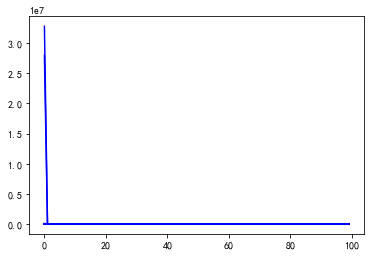

In [26]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(run, n_trials=100)

In [35]:
best_params = study.best_params
best_params

{'batch_size': 32,
 'epochs': 80,
 'learning_rate': 0.0032715725806322527,
 'optimizer': tensorflow.python.keras.optimizer_v2.adam.Adam,
 'units': 285}

In [36]:
best_value=study.best_value
best_value

269.5370805346891

In [37]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
display(df)
df.to_csv('285_LSTM_q=点预测_100次tail_无Dropout层的超参数确定实验结果.csv')

,number,value,params_batch_size,params_epochs,params_learning_rate,params_optimizer,params_units,state
0,0,277.591271,512,40,0.005228,<class 'tensorflow.python.keras.optimizer_v2.a...,105,COMPLETE
1,1,276.859474,256,30,0.015787,<class 'tensorflow.python.keras.optimizer_v2.a...,420,COMPLETE
2,2,290.435189,8,90,0.031396,<class 'tensorflow.python.keras.optimizer_v2.a...,230,COMPLETE
3,3,273.513384,128,90,0.003015,<class 'tensorflow.python.keras.optimizer_v2.a...,430,COMPLETE
4,4,271.882338,32,80,0.001329,<class 'tensorflow.python.keras.optimizer_v2.a...,75,COMPLETE
...,...,...,...,...,...,...,...,...
95,95,272.838690,64,90,0.001569,<class 'tensorflow.python.keras.optimizer_v2.a...,180,COMPLETE
96,96,271.135127,32,100,0.004500,<class 'tensorflow.python.keras.optimizer_v2.a...,145,COMPLETE
97,97,270.864126,32,80,0.010127,<class 'tensorflow.python.keras.optimizer_v2.a...,175,COMPLETE
98,98,270.865310,32,60,0.003919,<class 'tensorflow.python.keras.optimizer_v2.a...,215,COMPLETE


D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: ExperimentalWarning:

plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.



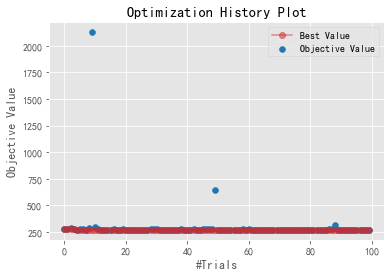

In [38]:
plot_optimization_history(study);